In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


In [2]:
# importing dataset 
df = pd.read_csv("/kaggle/input/the-movies-dataset/ratings_small.csv")
print(df.shape)
df.head(5)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
# Data cleaning
#check is null values in data 
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [5]:
from sklearn.utils import shuffle
shuffled_df = shuffle(df)
shuffled_df.shape

(100004, 4)

In [6]:
print(shuffled_df["rating"].max())
shuffled_df["rating"] = shuffled_df["rating"] / shuffled_df["rating"].max()

testing_df = shuffled_df.iloc[-1000:]
training_df = shuffled_df.iloc[:-1000]

print(testing_df.shape, training_df.shape)

5.0
(1000, 4) (99004, 4)


In [7]:
from tensorflow.keras.layers import Dense, Embedding, Input, Dot, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

embedding_size = 50
number_of_users = df["userId"].max() + 1
number_of_movies = df["movieId"].max() + 1

# Embedding each user into a latent vector
user_id_layer = Input(shape=(1,), name="user_id")
user_embedding = Embedding(input_dim=number_of_users, output_dim=embedding_size, name="User_Embeddings")(user_id_layer)
user_embedding = Reshape((embedding_size,))(user_embedding)

# Embedding each movie into a latent vector in the same space
movie_id_layer = Input(shape=(1,), name="movie_id")
movie_embedding = Embedding(input_dim=number_of_movies, output_dim=embedding_size, name="Movie_Embeddings")(movie_id_layer)
movie_embedding = Reshape((embedding_size,))(movie_embedding)

# Apply a dot product over the two embeddings
logit_rating = Dot(axes=1)([user_embedding, movie_embedding])

output_rating = Dense(1)(logit_rating)

model = Model(inputs=[user_id_layer, movie_id_layer], outputs=[output_rating])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Embeddings (Embedding)     (None, 1, 50)        33600       user_id[0][0]                    
__________________________________________________________________________________________________
Movie_Embeddings (Embedding)    (None, 1, 50)        8197500     movie_id[0][0]                   
______________________________________________________________________________________________

2022-10-14 10:27:46.175578: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


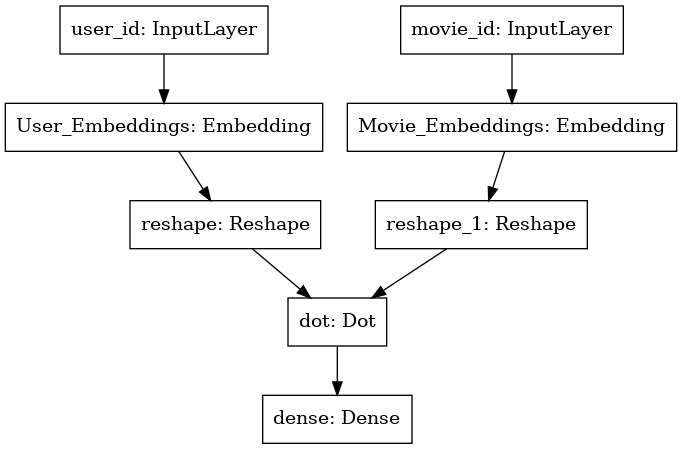

In [8]:
# import library and plot model
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=False, show_layer_names=True)

In [9]:
model.compile(optimizer="adam",loss="mse")

In [10]:
model.fit([training_df["userId"], training_df["movieId"]],
          y=training_df["rating"],
          batch_size=64,
          epochs=20,
          validation_split=0.1,
          callbacks=[EarlyStopping(monitor="val_loss", min_delta=0.05, patience=3)])


2022-10-14 10:27:47.767721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1393/1393 [==============================] - 86s 61ms/step - loss: 0.1377 - val_loss: 0.0350
Epoch 2/20
1393/1393 [==============================] - 85s 61ms/step - loss: 0.0259 - val_loss: 0.0347
Epoch 3/20
1393/1393 [==============================] - 84s 60ms/step - loss: 0.0139 - val_loss: 0.0370
Epoch 4/20
1393/1393 [==============================] - 83s 60ms/step - loss: 0.0088 - val_loss: 0.0386


In [11]:
predicted = model.predict(x=[testing_df["userId"], testing_df["movieId"]])

In [12]:
from tensorflow.keras.losses import MSE

testing_loss = MSE(testing_df["rating"], predicted)
testing_loss = sum(testing_loss) / len(testing_loss)
print(f"Testing Loss: {testing_loss}")


Testing Loss: 0.061361830681562424


In [13]:
print(f"predicted rating -> {predicted[0][0]*5}\n",f"Actual Rating -> {testing_df['rating'].iloc[0]*5}")

predicted rating -> 2.7470043301582336
 Actual Rating -> 4.0
